In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
%matplotlib inline
from torchvision.datasets import KMNIST
import torch
import math

In [2]:
# load the KMNIST dataset
from torchvision.transforms import ToTensor
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())

[INFO] loading the KMNIST dataset...


In [493]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class act(torch.nn.Module):
    def __init__(self, shape, a, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.a = a
        self.b = 0
    def forward(self, x):
        return torch.sin(self.a*x + self.b)

class SirenID(torch.nn.Module):
    def __init__(self, d, d_im, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, d_im**2),
            act(d_im**2, a=28),
        )
        self.scale = torch.nn.Parameter(torch.ones(1).to(device))
        self.pd=0
        # make x,y positional encodings
        xs = torch.linspace(start=-1, end=1, steps=d_im+2*self.pd, dtype=torch.float32, device=device)
        ys = torch.linspace(start=-1, end=1, steps=d_im+2*self.pd, dtype=torch.float32, device=device)
        self.xp, self.yp = torch.meshgrid(xs, ys)
        self.p = torch.stack([self.xp, self.yp,], dim=-1)
        self.d_im = d_im + 2*self.pd
        
        # initialize weights
        self.layers[0].weight.data.uniform_(-math.sqrt(6/d_im),math.sqrt(6/d_im))
        self.layers[0].bias.data.fill_(0)
        # self.layers[2].weight.data.uniform_(-math.sqrt(6/d),math.sqrt(6/d))
        
        self.wm = torch.nn.Parameter(torch.eye(self.d_im**2).to(device))

        # CNN portion
        k=1
        self.weight1 = torch.ones(1, 1, (2*k+1), (2*k+1)).to(device) # not a parameter, and no 0s
        # self.weight1 = torch.tensor([[[[1,1, 1], [1, 4, 1], [1, -1, 1]]]]).to(torch.float32).to(device)
        self.weight1.requires_grad = False
        self.pad = torch.nn.ZeroPad2d(k+self.pd)
        self.conv1 = lambda x : torch.nn.functional.conv2d(x, self.weight1)
        self.convs = lambda x : self.conv1(self.pad(x))
        
        self.lpad = torch.nn.ZeroPad2d(self.pd)
       
    def forward(self, x):
        # print(x.shape)
        y = self.convs(x).squeeze(1)
        
        batch = y.shape[0]
        # print(self.p.shape)
        # a = self.layers(self.p).squeeze()*self.scale
        a = self.wm
        y2 = y.reshape(batch, self.d_im**2)#.unsqueeze(1).unsqueeze(1)
        # print(a.shape, y2.shape)
        # print(torch.inner(self.m(a),y2).shape)
        return torch.inner(a,y2).reshape(self.d_im, self.d_im, batch).permute(2,0,1)
        
    def loss(self, x):
        fx = self.forward(x)
        # print(fx.shape, x.shape)
        return torch.nn.functional.mse_loss(fx, self.lpad(x).squeeze())
    
    def invert(self,x):
        y = self.convs(x).squeeze(1)
        batch = y.shape[0]
        y2 = y.reshape(batch, self.d_im**2)
        # direct solution by inversion to find a from y2, x
        self.wm = torch.nn.Parameter(torch.linalg.lstsq(y2, x.reshape(batch, self.d_im**2))[0])
        
 

In [506]:
dl = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=5000)

In [511]:
net = SirenID(25, 28).to(device)
net.train()
optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
epochs = 100
losses = []
tx = None
for x, y in dl:
    for i in tqdm(range(epochs)):
        optimizer.zero_grad()
        loss = net.loss(x.to(device))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        tx=x
    break


100%|██████████| 100/100 [00:00<00:00, 123.70it/s]


In [516]:
for x, y in dl:
    net.invert(x.to(device))
    break

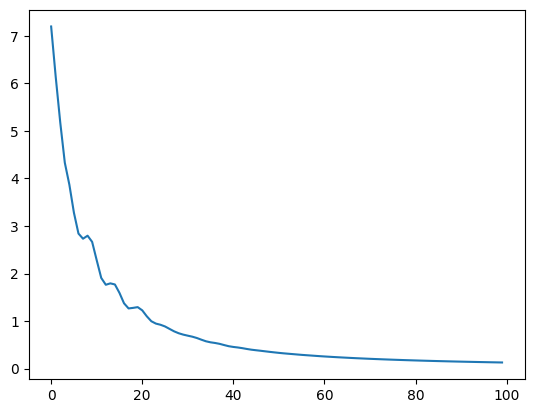

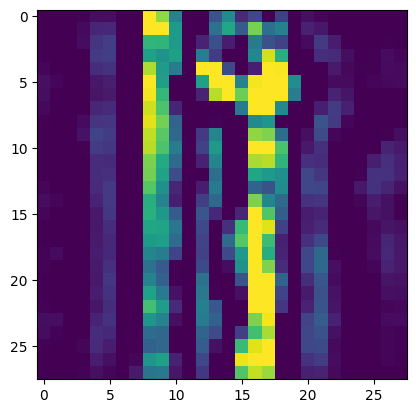

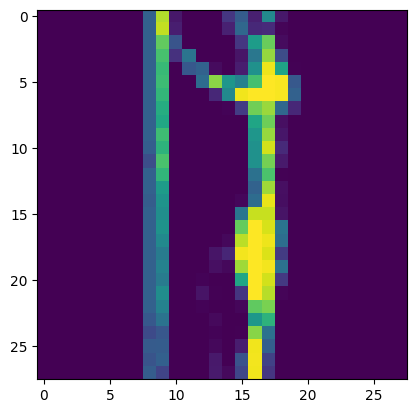

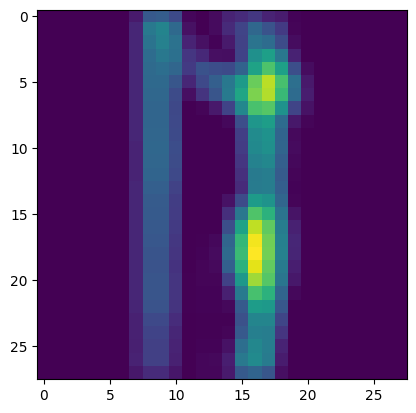

In [513]:

from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()
plt.close()
net.eval()
# x = tx
for x, y in dl:
    break
max = np.max(x.numpy()[0].squeeze())
min = np.min(x.numpy()[0].squeeze())
plt.imshow(net(x.to(device)).detach().cpu().numpy()[0].squeeze())
plt.clim(min, max)
plt.show()
plt.close()
plt.imshow(x.numpy()[0].squeeze())
plt.clim(min, max)
plt.show()
plt.close()
plt.imshow(net.convs(x.to(device)).detach().cpu().numpy()[0].squeeze())
# plt.clim(min, max)
plt.show()
plt.close()


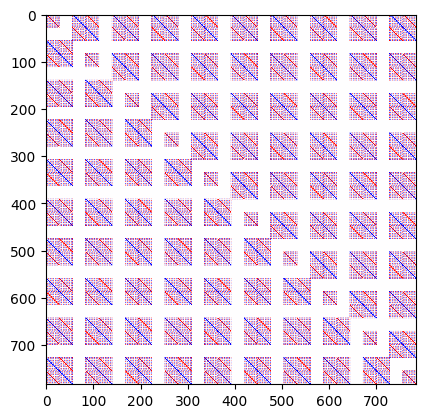

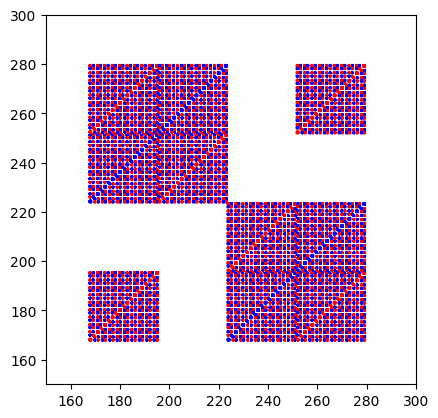

In [518]:
plt.imshow(net.wm.detach().cpu().numpy(), cmap='bwr')
plt.clim(-0.1, 0.1)
# plt.xlim(100, 400)
# plt.ylim(100, 400)
plt.show()
plt.close()
plt.imshow(net.wm.detach().cpu().numpy(), cmap='bwr')
plt.clim(-0.1, 0.1)
plt.xlim(150, 300)
plt.ylim(150, 300)
plt.show()